In [1]:
#!pip install efficientnet_pytorch timm pretrainedmodels segmentation_models_pytorch pandas albumentations matplotlib colorama

In [2]:
import os
import shutil
import pathlib

from PIL import Image
import pandas as pd
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets
import cv2
from torch.cuda import amp

import torchvision.transforms as T
import torchvision.transforms.functional as fn

from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.utils import make_grid

try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    import segmentation_models_pytorch as smp
except:
    !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
    import albumentations as A
    import segmentation_models_pytorch as smp
    from albumentations.pytorch import ToTensorV2


In [3]:
import timm
timm.list_models("*efficient*")

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientformerv2_l',
 'efficientformerv2_s0',
 'efficientformerv2_s1',
 'efficientformerv2_s2',
 'efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn',
 'efficientnet_b3_gn',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficie

In [4]:
inputs = []
dir1 =  './input/final-contrail-dataset/FinalData/FCI'
for root, dirs, files in os.walk(dir1):
    inputs.extend(files)
inputs = sorted(inputs)
        
# read annotations
target = []
dir2 = './input/final-contrail-dataset/FinalData/Contrail'
for root, dirs, files in os.walk(dir2):
    target.extend(files)
target = sorted(target)
inp = []
tar = []
for x in inputs:
    inp.append('./input/final-contrail-dataset/FinalData/FCI/'+x)
for x in target:
    tar.append('./input/final-contrail-dataset/FinalData/Contrail/'+x)
inputs = inp
target = tar

In [5]:
ext_data =[inputs,target]
pd.DataFrame(list(zip(inputs, target)),columns=["images","labels"]).to_csv("./contraildata/data_ext.csv",index=False)

In [6]:
# device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [7]:
! ls -l ./contraildata/train/data_train/kaggle/working/data/ | wc -l
# Count of val records
! ls -l ./contraildata/validation/data_valid/kaggle/working/data_valid/ | wc -l

20530
1857


In [8]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'effmodelv2fold0ext'
    comment       = 'unet-effb0-256x256-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'tf_efficientnet_b8','efficientnet--r','efficientnet-b5'
    train_bs      = 16
    valid_bs      = 1
    img_size      = [512, 512]
    epochs        = 50
    lr            = 1e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 1
    p_mixup         =0.8
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [10]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
#        A.Rotate(-20,crop_border=True,border_mode=cv2.BORDER_REFLECT,p=1.0),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        A.HorizontalFlip(p=0.3),
#         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
#        A.OneOf([
#            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
#            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
#        ], p=0.25),
#        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
#                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
 #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.OneOf([
         #   A.HueSaturationValue(hue_shift_limit=0.5, sat_shift_limit=0.5, val_shift_limit=0.5, always_apply=False, p=1.0),
            A.Downscale(interpolation=cv2.INTER_NEAREST,p=1.0),
            A.Sharpen(p=1.0)
           # A.ChannelShuffle(p=1.0)
        ],
        p=0.5),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//10, max_width=CFG.img_size[1]//50,
                         min_holes=1, fill_value=0.35, mask_fill_value=0.35, p=0.6),
        ToTensorV2(),

        ], p=1.0),
    

    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
#        A.Rotate(-20,crop_border=True,border_mode=cv2.BORDER_REFLECT,p=1.0),

        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ToTensorV2(),
        ], p=1.0)
}


hard_data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [11]:
import pandas as pd
from sklearn import model_selection
import numpy as np


In [12]:
df = pd.read_csv("./contraildata/data_ext.csv")

In [13]:
kf = model_selection.KFold(n_splits=20, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X=df)):
    df.loc[valid_idx, 'kfold'] = fold
    


In [14]:
df.to_csv("data_ext_fold.csv",index=False)



In [15]:
from torchvision.io import read_image

In [16]:
from torchvision import transforms
tg =transforms.Grayscale()

y= tg(read_image(df['labels'][0]))
y[y>0]=1
y.shape

torch.Size([1, 2000, 1987])

In [17]:
df['labels'][0]

'./input/final-contrail-dataset/FinalData/Contrail/contrail0.jpg'

In [18]:
class Dataset:
    def __init__(self,mode,fold,transform =None,is_inference=True):
        
        self.is_infer = is_inference
        self.fold =fold
        ROOT_PATH = './'

        df = pd.read_csv(f"{ROOT_PATH}/data_ext_fold.csv")

        
        if mode == 'train':
            df =df.loc[df.kfold != self.fold].copy().reset_index()
            
        elif mode =='valid':
            df =df.loc[df.kfold == self.fold].copy().reset_index()

        self.images = df['images']
        self.labels = df['labels']
        self.transform =transform
        
    def __getitem__(self, idx):
        x = fn.resize(read_image(self.images[idx]),size=[512,512],antialias=True)
        image = x.numpy().astype(float)
        
        if not self.is_infer : 
            
            y= fn.resize(tg(read_image(self.labels[idx])),size=[512,512],antialias=True)
            y[y>0]=1
            
            label = y.numpy().astype(float)
            

            
            if  self.transform :
                image = np.transpose(image, (1, 2, 0))
                label = np.transpose(label, (1, 2, 0))  
                
                data = self.transform(image=image, mask=label)
                image  = data['image']
                label  = data['mask']
                #image = np.transpose(image, (2, 0, 1))
                label = np.transpose(label, (2, 0, 1))               
            return image, label
        else :

            if  self.transform :
                data = self.transform(image=image)
                image  = data['image']
                #image = np.transpose(image, (2, 0, 1))
            return image
    
    def __len__(self):
        return len(self.images)
    
train_dataset = Dataset('train',fold=0,transform =data_transforms['train'],is_inference=False)    
val_dataset = Dataset('valid',fold=0,transform =data_transforms['valid'],is_inference=False)    
test_dataset = Dataset('test',fold=0,transform =data_transforms['valid'],is_inference=True)    


In [19]:
len(train_dataset), len(val_dataset), len(test_dataset)

(3011, 159, 3170)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs , 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(val_dataset, batch_size=1 , 
                              num_workers=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, 
                              num_workers=4, shuffle=False, pin_memory=True)

In [21]:
imgs, msks = next(iter(valid_loader))
imgs.size(), msks.size()

(torch.Size([1, 3, 512, 512]), torch.Size([1, 1, 512, 512]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


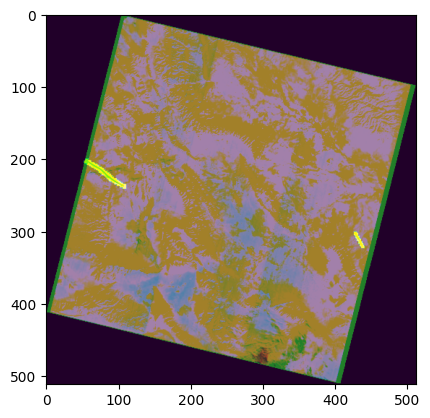

In [22]:
def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    plt.imshow(img)
    
    if mask is not None:
        plt.imshow(mask, alpha=0.9)

    plt.axis('off')

plt.imshow(imgs[0,].permute((1, 2, 0)).numpy())
plt.imshow(msks[0].permute((1, 2, 0)).numpy(), alpha=0.5)

In [23]:
import timm as timm
def plot_batch(imgs, msks, size=5):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()
        #img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()
        show_img(img, msk)
    plt.tight_layout()
    plt.show()
    


In [24]:
#timm.list_models("*efficientnet*")

In [25]:
#plot_batch(imgs,msks)

In [26]:
#encoder

In [27]:

##########################Anotha Banguh###########################
import segmentation_models_pytorch as smp
import timm
n_blocks = 4

n_blocks =4
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=True):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=0.5,
           # drop_path_rate=0.0,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 3, 128, 128))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.decoders.unetplusplus.decoder.UnetPlusPlusDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Sequential(
            nn.Conv2d(decoder_channels[n_blocks-1], 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.UpsamplingBilinear2d(scale_factor=1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features
    
#path='./exp/baselinev2/qishentrialv2_tf_efficientnet_b7_ns_last_epoch-00.bin'


def build_model(backbone):
    model = TimmSegModel(backbone,segtype='unet')
    model.to(CFG.device)
    return model

def load_model(path,backbone):
    model = build_model(backbone)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [28]:
import segmentation_models_pytorch as smp
import timm
n_blocks = 4

class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=True):
        super(TimmSegModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(6, 12, 3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(12, 36, 3, stride=1, padding=1, bias=False)
        self.mybn1 = nn.BatchNorm2d(6)
        self.mybn2 = nn.BatchNorm2d(12)
        self.mybn3 = nn.BatchNorm2d(36)     
        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=0.8,
            drop_path_rate=0.5,
            pretrained=True
        )
#        self.encoder.conv_stem.weight = nn.Parameter(self.encoder.conv_stem.weight.repeat(1, 6, 1, 1))
        self.encoder.conv_stem=nn.Conv2d(6, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

        self.encoder.blocks[5] = nn.Identity()
        self.encoder.blocks[6] = nn.Sequential(
            nn.Conv2d(self.encoder.blocks[4][2].conv_pwl.out_channels, 320, 1),
            nn.BatchNorm2d(320),
            nn.ReLU6(),
        )
        tr = torch.randn(1,6,64,64)
        g = self.encoder(tr)
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.decoders.unetplusplus.decoder.UnetPlusPlusDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], CFG.num_classes, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        #print(x.shape)

        x = F.relu6(self.mybn1(self.conv1(x)))
#        x = F.relu6(self.mybn2(self.conv2(x)))
#        x = F.relu6(self.mybn3(self.conv3(x)))
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

#path='./exp/baselinev2/qishentrialv2_tf_efficientnet_b7_ns_last_epoch-00.bin'


def build_model(backbone):
    model = TimmSegModel(backbone,segtype='unet')
    model.to(CFG.device)
    return model

def load_model(path,backbone):
    model = build_model(backbone)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [29]:
#import timm
#timm.list_models('*efficientnet*')

In [30]:
JaccardLoss = smp.losses.JaccardLoss(mode='binary')
DiceLoss    = smp.losses.DiceLoss(mode='binary')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='binary', per_image=True)
TverskyLoss = smp.losses.TverskyLoss(mode='binary', log_loss=False)

epsilon = 1e-5
smooth = 1
#DiceLoss=smp.utils.losses.DiceLoss()

def tversky(y_pred, y_true):
    y_true_pos = torch.flatten(y_true)
    y_pred_pos = torch.flatten(y_pred)
    true_pos = torch.sum(y_true_pos * y_pred_pos)
    false_neg = torch.sum(y_true_pos * (1-y_pred_pos))
    false_pos = torch.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

#def tversky_loss( y_pred,y_true):
#    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_pred,y_true):
    pt_1 = tversky(y_pred,y_true)
    gamma = 0.75
    return torch.pow((1-pt_1), gamma)
class Focal_Tversky():
    def __init__(self, eps=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        #self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        #y_pr = self.activation(y_pr)
        return 1.0*focal_tversky(y_pr,y_gt)
    
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
        
    return dice

def dice_score(y_true, y_pred, smooth=1e-6):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>0.5).to(torch.float32)
    i = torch.sum(y_pred * y_true, dim=(2, 3))
    u = torch.sum(y_pred, dim=(2, 3)) + torch.sum(y_true, dim=(2, 3))
    score = (2 * i + smooth)/(u + smooth)
    return torch.mean(score)

def dice_all(y_true, y_pred, smooth=1e-6):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred).to(torch.float32)
    i = torch.sum(y_pred * y_true)
    u = torch.sum(y_pred) + torch.sum(y_true)
    score = (2 * i + smooth)/(u + smooth)
    return score

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

def criterion2(y_pred, y_true):
    return LovaszLoss(y_pred, y_true)

In [31]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        do_mixup = False
        if random.random() < CFG.p_mixup:
            do_mixup = True
            images, masks, masks_sfl, lam = mixup(images, masks)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            if do_mixup:
                loss2 = criterion(y_pred, masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

In [32]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    masks_all =[]
    preds_all =[]
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        masks_all.append(masks)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        preds_all.append(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_dice_mod = dice_score(masks, y_pred).cpu().detach().numpy()

        val_scores.append([val_dice, val_jaccard,val_dice_mod])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')

    predictions = torch.flatten(torch.stack(preds_all))
    ground_truth = torch.flatten(torch.stack(masks_all))

    val_corret_dice =dice_all(ground_truth,predictions).cpu().detach().numpy()
    val_scores  = np.mean(val_scores, axis=0)
    
    print(val_corret_dice)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores,val_corret_dice

In [33]:
# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

In [34]:
def run_training(model,backbone, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
   # wandb.watch(model, log_freq=100)
    fold =0
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
        
    print(f"Start Training for Backbone ====> {backbone}")
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores,val_correct_dice = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard,val_dice_mod = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_correct_dice)
        history['Valid Jaccard'].append(val_jaccard)
        history['Valid Dice Mod'].append(val_dice_mod)

        
        # Log the metrics
 #       wandb.log({"Train Loss": train_loss, 
 #                  "Valid Loss": val_loss,
 #                  "Valid Dice": val_dice,
 #                  "Valid Jaccard": val_jaccard,
 #                  "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f} | Valid Dice Mod: {val_dice_mod:0.4f}')
        
        # deep copy the model
        if val_correct_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_correct_dice:0.4f})")
            best_dice    = val_correct_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            #run.summary["Best Dice"]    = best_dice
            #run.summary["Best Jaccard"] = best_jaccard
            #run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{CFG.exp_name}_{backbone}_best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            #wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"{CFG.exp_name}_{backbone}_last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [35]:
from torch.optim import lr_scheduler

def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [36]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    if mask_rle != '-': 
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
    return img.reshape(shape, order='F') 

In [37]:
fold =0
from tqdm import tqdm
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
for backbone in CFG.backbone :
    print(backbone)
    model     = build_model(backbone)
    
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model,backbone, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    
    
#run.finish()

tf_efficientnet_b8
cuda: NVIDIA A40

Start Training for Backbone ====> tf_efficientnet_b8
Epoch 1/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 28.00it/s, gpu_memory=1.82 GB, lr=0.00100, valid_loss=0.2144]


0.26401675
Valid Dice: 0.5031 | Valid Jaccard: 0.5031 | Valid Dice Mod: 0.5031
Valid Score Improved (-inf ---> 0.2640)
Model Saved


Epoch 2/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 27.19it/s, gpu_memory=1.88 GB, lr=0.00100, valid_loss=0.2077]


0.27296788
Valid Dice: 0.5031 | Valid Jaccard: 0.5031 | Valid Dice Mod: 0.5031
Valid Score Improved (0.2640 ---> 0.2730)
Model Saved


Epoch 3/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 29.31it/s, gpu_memory=1.88 GB, lr=0.00100, valid_loss=0.2009]


0.28878215
Valid Dice: 0.4468 | Valid Jaccard: 0.3808 | Valid Dice Mod: 0.4468
Valid Score Improved (0.2730 ---> 0.2888)
Model Saved


Epoch 4/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 29.00it/s, gpu_memory=1.92 GB, lr=0.00100, valid_loss=0.1812]


0.38588044
Valid Dice: 0.4783 | Valid Jaccard: 0.4121 | Valid Dice Mod: 0.4783
Valid Score Improved (0.2888 ---> 0.3859)
Model Saved


Epoch 5/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 29.86it/s, gpu_memory=1.96 GB, lr=0.00100, valid_loss=0.1858]


0.38721237
Valid Dice: 0.6137 | Valid Jaccard: 0.5493 | Valid Dice Mod: 0.6137
Valid Score Improved (0.3859 ---> 0.3872)
Model Saved


Epoch 6/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 29.18it/s, gpu_memory=1.95 GB, lr=0.00100, valid_loss=0.1807]


0.38250643
Valid Dice: 0.3672 | Valid Jaccard: 0.2988 | Valid Dice Mod: 0.3672


Epoch 7/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 29.96it/s, gpu_memory=1.94 GB, lr=0.00100, valid_loss=0.1756]


0.39685953
Valid Dice: 0.5067 | Valid Jaccard: 0.4393 | Valid Dice Mod: 0.5067
Valid Score Improved (0.3872 ---> 0.3969)
Model Saved


Epoch 8/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 29.73it/s, gpu_memory=1.92 GB, lr=0.00100, valid_loss=0.1712]


0.42120782
Valid Dice: 0.4757 | Valid Jaccard: 0.4069 | Valid Dice Mod: 0.4757
Valid Score Improved (0.3969 ---> 0.4212)
Model Saved


Epoch 9/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 28.06it/s, gpu_memory=1.88 GB, lr=0.00100, valid_loss=0.1747]


0.40716064
Valid Dice: 0.5266 | Valid Jaccard: 0.4584 | Valid Dice Mod: 0.5266


Epoch 10/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 29.28it/s, gpu_memory=1.93 GB, lr=0.00100, valid_loss=0.1650]


0.45643732
Valid Dice: 0.5635 | Valid Jaccard: 0.4949 | Valid Dice Mod: 0.5635
Valid Score Improved (0.4212 ---> 0.4564)
Model Saved


Epoch 11/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 29.06it/s, gpu_memory=1.93 GB, lr=0.00100, valid_loss=0.1674]


0.45758036
Valid Dice: 0.6983 | Valid Jaccard: 0.6338 | Valid Dice Mod: 0.6983
Valid Score Improved (0.4564 ---> 0.4576)
Model Saved


Epoch 12/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 29.40it/s, gpu_memory=1.95 GB, lr=0.00100, valid_loss=0.1634]


0.47696048
Valid Dice: 0.6358 | Valid Jaccard: 0.5694 | Valid Dice Mod: 0.6358
Valid Score Improved (0.4576 ---> 0.4770)
Model Saved


Epoch 13/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 26.90it/s, gpu_memory=1.90 GB, lr=0.00100, valid_loss=0.1729]


0.44502366
Valid Dice: 0.5917 | Valid Jaccard: 0.5279 | Valid Dice Mod: 0.5917


Epoch 14/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 27.69it/s, gpu_memory=1.95 GB, lr=0.00100, valid_loss=0.1559]


0.48802328
Valid Dice: 0.6366 | Valid Jaccard: 0.5679 | Valid Dice Mod: 0.6366
Valid Score Improved (0.4770 ---> 0.4880)
Model Saved


Epoch 15/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 27.97it/s, gpu_memory=2.01 GB, lr=0.00100, valid_loss=0.1598]


0.46233544
Valid Dice: 0.6103 | Valid Jaccard: 0.5435 | Valid Dice Mod: 0.6103


Epoch 16/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 28.58it/s, gpu_memory=1.98 GB, lr=0.00100, valid_loss=0.1387]


0.5776626
Valid Dice: 0.5921 | Valid Jaccard: 0.5211 | Valid Dice Mod: 0.5921
Valid Score Improved (0.4880 ---> 0.5777)
Model Saved


Epoch 17/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 27.67it/s, gpu_memory=1.98 GB, lr=0.00100, valid_loss=0.1399]


0.5981339
Valid Dice: 0.6275 | Valid Jaccard: 0.5617 | Valid Dice Mod: 0.6275
Valid Score Improved (0.5777 ---> 0.5981)
Model Saved


Epoch 18/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 27.97it/s, gpu_memory=1.90 GB, lr=0.00100, valid_loss=0.1369]


0.61584926
Valid Dice: 0.6693 | Valid Jaccard: 0.6028 | Valid Dice Mod: 0.6693
Valid Score Improved (0.5981 ---> 0.6158)
Model Saved


Epoch 19/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 28.03it/s, gpu_memory=1.91 GB, lr=0.00100, valid_loss=0.1366]


0.61630577
Valid Dice: 0.6683 | Valid Jaccard: 0.6048 | Valid Dice Mod: 0.6683
Valid Score Improved (0.6158 ---> 0.6163)
Model Saved


Epoch 20/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 28.95it/s, gpu_memory=2.00 GB, lr=0.00100, valid_loss=0.1488]


0.5661541
Valid Dice: 0.6474 | Valid Jaccard: 0.5825 | Valid Dice Mod: 0.6474


Epoch 21/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 29.51it/s, gpu_memory=1.96 GB, lr=0.00100, valid_loss=0.1346]


0.62393045
Valid Dice: 0.7114 | Valid Jaccard: 0.6469 | Valid Dice Mod: 0.7114
Valid Score Improved (0.6163 ---> 0.6239)
Model Saved


Epoch 22/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 28.24it/s, gpu_memory=1.91 GB, lr=0.00100, valid_loss=0.1344]


0.60162324
Valid Dice: 0.6438 | Valid Jaccard: 0.5773 | Valid Dice Mod: 0.6438


Epoch 23/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 27.74it/s, gpu_memory=1.96 GB, lr=0.00100, valid_loss=0.1399]


0.5902663
Valid Dice: 0.6279 | Valid Jaccard: 0.5604 | Valid Dice Mod: 0.6279


Epoch 24/50

Train :  97%|█████████▋| 184/189 [02:13<00:03,  1.60it/s, gpu_mem=33.37 GB, lr=0.00100, train_loss=0.2171]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 159/159 [00:05<00:00, 29.89it/s, gpu_memory=1.99 GB, lr=0.00100, valid_loss=0.1305]


0.63208526
Valid Dice: 0.6685 | Valid Jaccard: 0.6016 | Valid Dice Mod: 0.6685


Epoch 39/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 30.08it/s, gpu_memory=1.94 GB, lr=0.00100, valid_loss=0.1247]


0.6506376
Valid Dice: 0.6849 | Valid Jaccard: 0.6201 | Valid Dice Mod: 0.6849
Valid Score Improved (0.6375 ---> 0.6506)
Model Saved


Epoch 40/50

Valid : 100%|██████████| 159/159 [00:05<00:00, 30.08it/s, gpu_memory=2.05 GB, lr=0.00100, valid_loss=0.1301]


0.62250805
Valid Dice: 0.6513 | Valid Jaccard: 0.5840 | Valid Dice Mod: 0.6513


Epoch 41/50

Valid :  21%|██        | 33/159 [00:01<00:04, 27.80it/s, gpu_memory=1.74 GB, lr=0.00100, valid_loss=0.1174]

In [ ]:
bla

In [ ]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'effb8modelv2fold0'
    comment       = 'unet-effb0-256x256-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'tf_efficientnet_b8','efficientnet--r','efficientnet-b5'
    train_bs      = 16
    valid_bs      = train_bs
    img_size      = [512, 512]
    epochs        = 100
    lr            = 1e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 1
    p_mixup         =0.0
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
###Stage2 :
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_one_epochstage2(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        do_mixup = False
        if random.random() < CFG.p_mixup:
            do_mixup = True
            images, masks, masks_sfl, lam = mixup(images, masks)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion2(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            if do_mixup:
                loss2 = criterion(y_pred, masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss


In [ ]:
def criterion2(y_pred, y_true):
    return DiceLoss(y_pred, y_true)

In [ ]:
def run_trainingstage2(model,backbone, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
   # wandb.watch(model, log_freq=100)
    fold =0
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
        
    print(f"Start Training for Backbone ====> {backbone}")
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epochstage2(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores,val_correct_dice = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard,val_dice_mod = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_correct_dice)
        history['Valid Jaccard'].append(val_jaccard)
        history['Valid Dice Mod'].append(val_dice_mod)

        
        # Log the metrics
 #       wandb.log({"Train Loss": train_loss, 
 #                  "Valid Loss": val_loss,
 #                  "Valid Dice": val_dice,
 #                  "Valid Jaccard": val_jaccard,
 #                  "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_correct_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f} | Valid Dice Mod: {val_dice_mod:0.4f}')
        
        # deep copy the model
        if val_correct_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_correct_dice:0.4f})")
            best_dice    = val_correct_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            #run.summary["Best Dice"]    = best_dice
            #run.summary["Best Jaccard"] = best_jaccard
            #run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{CFG.exp_name}_{backbone}_best_epochstage2-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            #wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"{CFG.exp_name}_{backbone}_last_epochstage2-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(val_dataset, batch_size=2 , 
                              num_workers=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs//2, 
                              num_workers=4, shuffle=False, pin_memory=True)

fold =0
from tqdm import tqdm
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
path='./effb8modelv2fold0_tf_efficientnet_b8_best_epoch-00.bin'

for backbone in CFG.backbone :
    print(backbone)
    model     = build_model(backbone)
    model =load_model(path,backbone)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_trainingstage2(model,backbone, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(val_dataset, batch_size=16 , 
                              num_workers=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs//2, 
                              num_workers=4, shuffle=False, pin_memory=True)

fold =0
from tqdm import tqdm
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
path='./exp/effb8modelv2_tf_efficientnet_b8_best_epochstage2-00cv675.bin'

for backbone in CFG.backbone :
    print(backbone)
    model     = build_model(backbone)
    model =load_model(path,backbone)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_trainingstage2(model,backbone, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)

In [ ]:
####STAGE 3 

In [ ]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'qishentrialv384unetplus'
    comment       = 'unet-effb0-256x256-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'tf_efficientnet_b7_ns','efficientnet--r','efficientnet-b5'
    train_bs      = 12
    valid_bs      = train_bs
    img_size      = [384, 384]
    epochs        = 1
    lr            = 1e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 1
    p_mixup         =0.0
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
###Stage2 :
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_one_epochstage3(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        do_mixup = False
        if random.random() < CFG.p_mixup:
            do_mixup = True
            images, masks, masks_sfl, lam = mixup(images, masks)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion2(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            if do_mixup:
                loss2 = criterion(y_pred, masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss


In [ ]:
def train_csv(x,path):
    y= x.replace("/kaggle/working/data/",f"{path}")
    return y

class Dataset:
    def __init__(self,mode,transform =None,is_inference=True):
        
        self.is_infer = is_inference

        
        if mode == 'train':
            ROOT_PATH = './contraildata/train'
            DATA_PATH = './contraildata/train/data_train/kaggle/working/data/'
        elif mode =='valid':
            ROOT_PATH = './contraildata/'
            DATA_PATH = './contraildata/validation/data_valid/kaggle/working/data_valid/'
        elif mode == 'all' :
            ROOT_PATH = './contraildata/all'
            DATA_PATH = './contraildata/all/'
            
        else :
            ROOT_PATH = './contraildata/'
            DATA_PATH = './contraildata/validation/data_valid/kaggle/working/data_valid/'
            
        if mode =='all':
            
            df = pd.read_csv(f"{ROOT_PATH}/data_all.csv")
            
        else:

            df = pd.read_csv(f"{ROOT_PATH}/data.csv")
        
            df["image"]=df["image"].apply(lambda x: train_csv(x,DATA_PATH))
        
            if not (self.is_infer):
                df["label"]=df["label"].apply(lambda x:train_csv(x,DATA_PATH))

        self.images = df['image']
        self.labels = df['label']
        self.transform =transform
    def __getitem__(self, idx):
        image = np.load(self.images[idx]).astype(float)
        if not self.is_infer : 
            
            label = np.load(self.labels[idx]).astype(float)
            
            if  self.transform :
                data = self.transform(image=image, mask=label)
                image  = data['image']
                label  = data['mask']
                image = np.transpose(image, (2, 0, 1))
                label = np.transpose(label, (2, 0, 1))                
            return torch.tensor(image), torch.tensor(label)
        else :

            if  self.transform :
                data = self.transform(image=image)
                image  = data['image']
                image = np.transpose(image, (2, 0, 1))
            return torch.tensor(image)
    
    def __len__(self):
        return len(self.images)
    
train_dataset = Dataset('train',transform =data_transforms['train'],is_inference=False)    
val_dataset = Dataset('valid',transform =data_transforms['valid'],is_inference=False)    
all_dataset = Dataset('all',transform =data_transforms['train'],is_inference=False)    

test_dataset = Dataset('test',transform =data_transforms['valid'],is_inference=True)    

train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs , 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)

all_loader = DataLoader(all_dataset, batch_size=8 , 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(val_dataset, batch_size=4 , 
                              num_workers=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, 
                              num_workers=4, shuffle=False, pin_memory=True)

In [ ]:
def run_trainingstage3(model,backbone, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
   # wandb.watch(model, log_freq=100)
    fold =0
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
        
    print(f"Start Training for Backbone ====> {backbone}")
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epochstage3(model, optimizer, scheduler, 
                                           dataloader=all_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores,val_correct_dice = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard,val_dice_mod = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_correct_dice)
        history['Valid Jaccard'].append(val_jaccard)
        history['Valid Dice Mod'].append(val_dice_mod)

        
        # Log the metrics
 #       wandb.log({"Train Loss": train_loss, 
 #                  "Valid Loss": val_loss,
 #                  "Valid Dice": val_dice,
 #                  "Valid Jaccard": val_jaccard,
 #                  "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_correct_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f} | Valid Dice Mod: {val_dice_mod:0.4f}')
        
        # deep copy the model
        if val_correct_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_correct_dice:0.4f})")
            best_dice    = val_correct_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            #run.summary["Best Dice"]    = best_dice
            #run.summary["Best Jaccard"] = best_jaccard
            #run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{CFG.exp_name}_{backbone}_best_epochstage3-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            #wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"{CFG.exp_name}_{backbone}_last_epochstage3-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
fold =0
from tqdm import tqdm
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
path='./qishentrialv384unetplus_tf_efficientnet_b7_ns_best_epochstage2-00.bin'

for backbone in CFG.backbone :
    print(backbone)
    model     = build_model(backbone)
    model =load_model(path,backbone)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_trainingstage3(model,backbone, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)

In [ ]:
backbones =['efficientnet_b0']


In [ ]:
%%time
out_rle=[]

preds = []
truth= []
preds_all =[]
truth_all =[]
preds_new=[]
for index,(imgs,msks) in enumerate(valid_loader):
        imgs = imgs.to(CFG.device, dtype=torch.float)
        msks = msks.to(CFG.device, dtype=torch.float)
        pred_bb=0
        for backbone in backbones:
            model = load_model("qishentrial_efficientnet-b0_best_epoch-00.bin",backbone)
            with torch.no_grad():
                pred = model(imgs)
                pred_bb+=pred
        pred = (nn.Sigmoid()(pred_bb/len(backbones))>0.5).double()
        preds.append(pred)
        preds_new.append(pred.cpu().detach())
imgs  = imgs.cpu().detach()
msks  =msks.cpu().detach()

preds_new = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()
#truth = torch.mean(torch.stack(msks, dim=0), dim=0).cpu().detach()


#out_reversed = np.array([o.cpu().permute(1,2,0).numpy() for o in preds])
#for e in out_reversed:
#    out_rle.append(e)

In [ ]:
pred_bb =torch.randn(64,1,512,512)

cv2.resize(pred_bb[0].numpy().reshape(512,512),(256,256),interpolation=cv2.INTER_NEAREST).shape

In [ ]:
backbone=['efficientnet_b0']
imgs,msks = next(iter(valid_loader))
imgs = imgs.to(CFG.device, dtype=torch.float)
out_rle=[]

preds = []
for fold in range(1):
    
    for bb in backbone:
        
        model = load_model(f"qishentrial_efficientnet-b0_best_epoch-00.bin",bb)
        with torch.no_grad():
            pred_tmp = model(imgs)
            pred+=pred_tmp
    pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

out_reversed = np.array([o.cpu().permute(1,2,0).numpy() for o in preds])
for e in out_reversed:
    out_rle.append(e)

In [ ]:
def resizeMask(mask, w, h):
    
    resmask = np.zeros((h, w, mask.shape[2]))
    for i in range(mask.shape[2]):
        resmask[...,i] = cv2.resize(mask[...,i], (w,h))
        
    return resmask

In [ ]:
b,c,h,w =preds.shape

def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))

In [ ]:
msks

In [ ]:
plot_batch(imgs, preds, size=2)

In [ ]:
plot_batch(imgs, msks, size=5)